<a href="https://colab.research.google.com/github/drewlinsley/CSSM/blob/main/notebooks/transformer_cssm_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TransformerCSSM: Iterative Attention for Visual Reasoning

This notebook introduces **TransformerCSSM**, a model that combines the parallelizability of state space models with the expressiveness of transformer-style attention.

**Model Performance:** 88.50% accuracy on Pathfinder-14

---

## Table of Contents

1. **What is CSSM?** - Convolutions in spectral domain, log-space stability
2. **The Transformer's Trick** - Instant attention at all positions
3. **When Iterative Attention Helps** - The Pathfinder task
4. **CSSM as a Solution** - Parallel RNNs, but limited expressiveness
5. **Insights from the hGRU** - Bilinear terms and growing receptive fields
6. **TransformerCSSM** - Bringing it all together
7. **Hands-On Analysis** - Gradients, mechanisms, and interpretability

In [ ]:
#@title Setup: Install dependencies and download checkpoint { display-mode: "form" }
import os
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install JAX with GPU support
    !pip install -q jax[cuda12] flax optax tensorflow

    # Clone CSSM repo
    if not os.path.exists('CSSM'):
        !git clone https://github.com/drewlinsley/CSSM.git
    
    # Add to path
    if 'CSSM' not in sys.path:
        sys.path.insert(0, 'CSSM')

    # Download checkpoint (--no-check-certificate for expired SSL cert)
    CHECKPOINT_URL = "https://connectomics.clps.brown.edu/tf_records/transformer_cssm_kqv64_epoch20.pkl"
    CHECKPOINT_PATH = "transformer_cssm_checkpoint.pkl"

    if not os.path.exists(CHECKPOINT_PATH):
        print(f"Downloading checkpoint from {CHECKPOINT_URL}...")
        !wget -q --no-check-certificate {CHECKPOINT_URL} -O {CHECKPOINT_PATH}
        print("Download complete!")
else:
    # Local paths - assumes running from CSSM/notebooks/
    if '..' not in sys.path:
        sys.path.insert(0, '..')
    CHECKPOINT_PATH = "../checkpoints/KQV_64/epoch_20/checkpoint.pkl"

print(f"Checkpoint path: {CHECKPOINT_PATH}")
print(f"Running in {'Colab' if IN_COLAB else 'local'} environment")

# Verify imports work
try:
    from src.models.simple_cssm import SimpleCSSM
    print("[OK] Successfully imported SimpleCSSM")
    MODEL_AVAILABLE = True
except ImportError as e:
    print(f"[X] Could not import SimpleCSSM: {e}")
    print("  Some analysis cells will be skipped.")
    MODEL_AVAILABLE = False

---
# Part I: Background
---

## 1. What is CSSM?

**CSSM (Cepstral State Space Model)** is a recurrent neural network designed for efficient visual processing. Think of it as an RNN that can run in parallel.

### The Core Idea

A standard RNN updates its hidden state like this:

$$h_{t+1} = A \cdot h_t + B \cdot x_t$$

The problem? Each timestep depends on the previous one, so you must compute them **sequentially**. For T timesteps, that's O(T) serial operations—slow on GPUs that thrive on parallelism.

### Why Spectral Domain?

CSSM performs spatial convolutions using the **Fast Fourier Transform (FFT)**:

$$\text{Conv}(K, X) = F^{-1}(F(K) \odot F(X))$$

**In plain English:** Instead of sliding a kernel across an image (expensive), we:
1. Transform both kernel and image to frequency domain (FFT)
2. Multiply them element-wise (cheap!)
3. Transform back (inverse FFT)

This reduces spatial convolution from O(N²) to O(N log N). This change is critical for a recurrent network, as the kernel size (N) will grow over time. In the spectral domain, the kernel size is fixed regardless of the number of timesteps!

### Why Log-Space (GOOM)?

Another fundamental problem with RNNs is training. When you multiply many numbers together over time (like decay rates), values can explode or vanish:

$$h_T = \lambda^T \cdot h_0$$

**GOOM (Generalized Order of Magnitude)** solves this by working in log-space, where multiplications become additions. But standard log-space can't handle negative numbers—a problem since state matrices have negative eigenvalues.

GOOM's trick: encode sign in a complex angle:

$$\text{goom.log}(x) = \log |x| + i \theta_x \quad \text{where } \theta_x = \begin{cases} 0 & x > 0 \\ \pi & x < 0 \end{cases}$$

Since $e^{i\pi} = -1$, this preserves sign through exponentiation.

**Bottom line:** The CSSM achieves stable and parallel computation of recurrent convolutions without exploding or vanishing gradients, and which can serve as the foundation for more complex recurrent architectures.

## 2. The Transformer's Trick: Instant Attention

Transformers revolutionized deep learning with **self-attention**:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right) V$$

### What This Means

Every position in the input can instantly "attend to" every other position:
- **Q (Query)**: "What am I looking for?"
- **K (Key)**: "What do I contain?"
- **V (Value)**: "What information do I carry?"

The $QK^T$ product computes similarity between all pairs of positions **in one shot**.

### The Good

- **Fully parallelizable**: No sequential dependencies
- **Global context**: Any position can see any other position
- **Scales well**: GPUs love matrix multiplications

### The Catch

- **O(N²) complexity**: Comparing all pairs of N positions is expensive
- **All-or-nothing**: Attention is computed once, no refinement in the given layer. Depth is needed, for example, to develop more advanced attentional operations (e.g., perceptual groups)
- **No iteration**: Can't "change your mind" or backtrack

## 3. When Iterative Attention Helps: The Pathfinder Task

Some visual tasks require **iterative reasoning**—you can't solve them in one glance.

### The Pathfinder Challenge

The task: **Are the two dots connected by a continuous curve?**

The image contains:
- Two marker dots (endpoints)
- A potential connecting contour (curved path)
- Distractor curves (noise to confuse you)

**Why is this hard?**
- It's not really that hard for Humans! But it can take time to solve (although usually still $<$ 1 second)
- The contour can be long and winding
- Distractors look similar to the real path
- You need to "trace" the curve step by step

### Why Iterative Attention?

Imagine tracing a contour with your finger:

1. **Start at one dot**
2. **Follow the curve locally** (look at nearby pixels)
3. **Keep extending** your search
4. **Backtrack if stuck** (hit a dead end? try another direction)
5. **Succeed when you reach the other dot**

This is fundamentally **iterative**—you make local decisions that accumulate into a global answer.

### The Transformer Problem

A standard transformer computes attention once and makes a decision. But for Pathfinder:
- **Early layers** can only see local structure
- **To trace a long curve**, you need many layers stacked (deep = slow)
- **No backtracking**: if an early layer makes a mistake, later layers can't fix it

### The RNN Solution (and its flaw)

An RNN can iterate naturally:
- Each timestep refines the answer
- Information spreads gradually across the image
- More timesteps = larger effective receptive field
- The growing receptive field is smart: it can ignore irrelevant stuff, it can become sensitive to curvy lines, etc.

**So why not just use an RNN?**: Traditional RNNs are sequential -> O(T) time -> slow on GPUs. This is a bad fit for the architecture of state-of-the-art GPUs, which are designed for massive parallelization and minimal data transfer across the chip. RNNs are sequential and require intense data transfer, especially in the case of vision RNNs, since large activities for intermediate timesteps have to be shuttled in and out of fast memory. See the following for an expanded discussion: Gu, A., & Dao, T. (2023). Mamba: Linear-Time Sequence Modeling with Selective State Spaces. arXiv:2312.00752

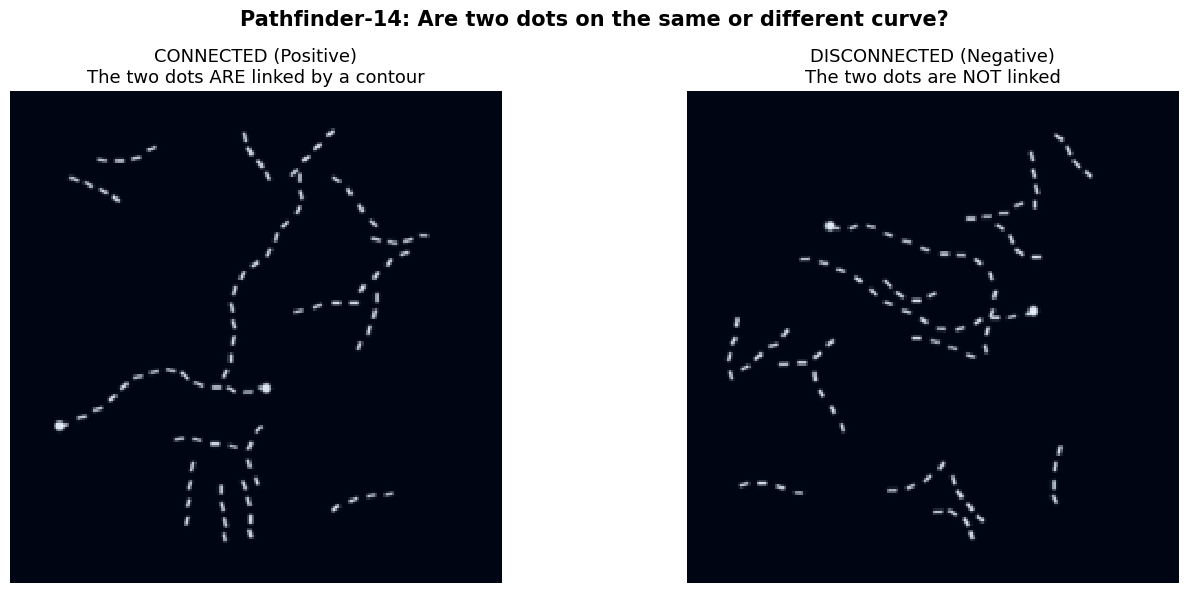


Task: Determine if the two dots are connected by a continuous curve.
Challenge: Distractor curves make it hard—you must trace carefully!


In [ ]:
# Load and visualize actual Pathfinder-14 images
import matplotlib.pyplot as plt
import numpy as np
import os
# ssl module is no longer needed if using wget

# Load sample images (works both locally and on Colab)
if IN_COLAB:
    # urllib.request is no longer directly used for download
    SAMPLE_URL = "https://connectomics.clps.brown.edu/tf_records/pathfinder_samples.npz"
    if not os.path.exists("pathfinder_samples.npz"):
        print("Downloading Pathfinder samples...")
        # Use wget with --no-check-certificate, similar to the checkpoint download
        !wget -q --no-check-certificate {SAMPLE_URL} -O pathfinder_samples.npz
    data = np.load("pathfinder_samples.npz")
    pos_img, neg_img = data['pos'], data['neg']
else:
    # Load from TFRecords locally
    import tensorflow as tf
    tf.config.set_visible_devices([], 'GPU')

    TFRECORD_DIR = '/home/dlinsley/pathfinder_tfrecord/difficulty_14/val'

    def parse_example(example):
        features = tf.io.parse_single_example(example, {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        })
        image = tf.io.decode_raw(features['image'], tf.float32)
        image = tf.reshape(image, [224, 224, 3])
        return image, features['label']

    val_files = sorted(tf.io.gfile.glob(f'{TFRECORD_DIR}/*.tfrecord'))
    ds = tf.data.TFRecordDataset(val_files[:1]).map(parse_example)

    pos_img, neg_img = None, None
    for img, label in ds:
        if label.numpy() == 1 and pos_img is None:
            pos_img = img.numpy()
        elif label.numpy() == 0 and neg_img is None:
            neg_img = img.numpy()
        if pos_img is not None and neg_img is not None:
            break

# Fix normalization
pos_img = (pos_img - pos_img.min()) / (pos_img.max() - pos_img.min())
neg_img = (neg_img - neg_img.min()) / (neg_img.max() - neg_img.min())

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(pos_img, interpolation="none")
axes[0].set_title('CONNECTED (Positive)\nThe two dots ARE linked by a contour', fontsize=13)
axes[0].axis('off')

axes[1].imshow(neg_img, interpolation="none")
axes[1].set_title('DISCONNECTED (Negative)\nThe two dots are NOT linked', fontsize=13)
axes[1].axis('off')

plt.suptitle('Pathfinder-14: Are two dots on the same or different curve?', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTask: Determine if the two dots are connected by a continuous curve.")
print("Challenge: Distractor curves make it hard—you must trace carefully!")

## 4. CSSM: A Parallel RNN (But Limited)

The CSSM offers a potential solution to Pathfinder: **an RNN that runs in parallel**.

### The Associative Scan Trick

For linear recurrences of the form:

$$h_{t+1} = A \cdot h_t + b_t$$

We can use the **associative scan** to compute all timesteps in O(log T) parallel time instead of O(T) sequential time. To be clear: this is a HUGE gain over regular RNNs. (TODO: Show this empirically)

**How?** The operation $(A_2, b_2) \circ (A_1, b_1) = (A_2 A_1, A_2 b_1 + b_2)$ is associative, so we can reorganize the computation into a tree:

```
t=0    t=1    t=2    t=3    t=4    t=5    t=6    t=7
  \    /        \    /        \    /        \    /
   [0:1]         [2:3]         [4:5]         [6:7]      <- Level 1
      \          /                \          /
       [0:3]                       [4:7]                <- Level 2
           \                      /
                      [0:7]                             <- Level 3
```

Instead of 8 sequential steps, we need only 3 parallel levels (log${_2}$(N) steps).

### The key CSSM limitation

Basic CSSM computes a **single state variable**:

$$h_{t+1} = \lambda \cdot h_t + \text{input}$$

This state variable could be thought of as a very restricted form of self-attention. Like a transformer with only **one** of Q, K, or V variables (and of course, no interactions between these).

**Our question for today: Can we make a CSSM that benefits from the Query-Key interaction of transformers?**

## 5. Insights from the hGRU

A key hint came from the **hGRU (horizontal Gated Recurrent Unit)**—a sequential and nonlinear RNN we developed that successfully solves Pathfinder. The hGRU was inspired by Neuroscience, and allows for feedback between units designed to mimic excitatory and inhibitory neurons in visual cortex. Those interactions change over space and time, and the hGRU has been found capable of modeling human-level performance in segmentation, while also learning human-like illusions as a by-product. Read the following papers for more info:
- [Complementary surrounds explain diverse contextual phenomena across visual modalities.](https://serre.lab.brown.edu/papers/complementary-surrounds-explain-diversity-2018.pdf)
- [Learning long-range spatial dependencies with horizontal gated-recurrent units](https://serre.lab.brown.edu/papers/learning-long-range-spatial-dependencies-2018.pdf)
- [Recurrent neural circuits for contour detection](https://serre.lab.brown.edu/papers/recurrent-neural-circuits-contours-detection-2020.pdf)
- [Disentangling neural mechanisms for perceptual grouping](https://openreview.net/forum?id=HJxrVA4FDS)

### The hGRU

The hGRU is defined by a system of coupled differential equations that govern the evolution of the potential $X$ and the activity $Y$ for a unit $k$ at location $(x,y)$. Crucially, unit activities are computed with **spatial convolutions**, which allow $X$ and $Y$ to spread spatially with nonlinear interactions. Let $\ast$ denote the convolution operator. The dynamics are:

$$\eta \dot{X}_k = \Big[ \underbrace{\xi L_k}_{\text{Feedforward Input}} - \underbrace{(\alpha X_k + \mu) T_k}_{\text{Local Self-Normalization}} - \underbrace{(\beta X_k + \nu) S_k}_{\text{Far Surround Suppression}} \Big]_+$$

$$\tau \dot{Y}_k = \Big[ \underbrace{\delta Q_k}_{\text{Local Excitation}} + \underbrace{\gamma P_k}_{\text{Near Surround Facilitation}} \Big]_+ - \underbrace{\sigma^2 Y_k}_{\text{Passive Decay}}$$

where $L_k$ represents the external feedforward drive (e.g., an encoded image feature or video frame). The internal dynamics are driven by four distinct pools of activity. $Q_k$ and $T_k$ represent local and across-feature interactions (known in Neuroscience as "intracolumnar" horizontal connections), while $P_k$ and $S_k$ represent long-range and across-space interactions ("intercolumnar" horizontal connections):

$$Q_k = (W_{\text{local}} \ast X)_k \quad \text{(Local Excitation pools Potential)}$$

$$T_k = (W_{\text{norm}} \ast Y)_k \quad \text{(Local Inhibition pools Output)}$$

$$P_k = (K_{\text{near}} \ast X)_k \quad \text{(Facilitation pools Potential)}$$

$$S_k = (K_{\text{far}} \ast Y)_k \quad \text{(Suppression pools Output)}$$


### The hGRU's Secret: Bilinear Interactions

The hGRU has two interacting cell populations:
- **Excitatory cells (X)**: Spread activation along contours
- **Inhibitory cells (Y)**: Suppress distractors

The critical insight is the **bilinear terms** in the $\dot{X}$ equation:

$$(\alpha X_k + \mu) \cdot T_k \quad \text{where} \quad T_k \propto Y$$

Since $T_k = (W_{\text{norm}} \ast Y)_k$, this "Local Self-Normalization" term creates an $X \cdot Y$ interaction. Similarly, the "Far Surround Suppression" term $(\beta X_k + \nu) \cdot S_k$ is also bilinear since $S_k \propto Y$.

**Our hypothesis:** Inhibitory unit dynamics are modulated by **products** of excitatory and inhibitory activity. This multiplicative interaction is much more expressive than simple addition—it allows inhibition to *gate* excitation, selectively suppressing activity based on context. **We believe this is a form of Transformer-like self-attention with a key difference—the attentional interactions between different positions grow incrementally over time, rather than being done in one-shot.**

### Growing Receptive Fields = Growing Attention

Each timestep, information spreads through a spatial kernel. After T timesteps:

- **t=1**: Each pixel sees its immediate neighbors
- **t=4**: Each pixel sees a moderate neighborhood  
- **t=8**: Each pixel sees a large region

The kernel **is re-applied to the same units over time**, causing effective receptive fields of the units to grow with each iteration.

**The bilinear interactions combined with recurrent convolution is like attention with a growing radius!**

At early timesteps, comparisons are local. At later timesteps, comparisons span the entire image. This allows the network to:
1. **Start with local edge detection**
2. **Gradually integrate** into longer contours
3. **Make global decisions** only when enough context is gathered

### The Challenge

The hGRU works great, but it's a traditional RNN. It is **sequential and slow**.

**Can we preserve the bilinear, growing-receptive-field dynamics of the hGRU in a parallelizable CSSM?**

---
# Part II: TransformerCSSM
---

## 6. TransformerCSSM: Bringing It Together

**TransformerCSSM** is our attempt to combine:
- **Parallel computation** (from CSSM's associative scan)
- **Query-Key interactions** (from transformers)
- **Growing receptive fields** (from hGRU)
- **Iterative refinement** (from RNNs)

### The Three States

| State | Name | Role |
|-------|------|------|
| **Q** | Query | Current representation seeking context |
| **K** | Key | Information available to match against |
| **A** | Attention | Accumulated Q-K correlations over time |

### The Update Equations

Let $W$ denote the learned spatial kernel (applied via FFT convolution).

**Query:** $\quad Q_{t+1} = \lambda_Q Q_t + w (W * K_t) + \alpha (W * A_t) + U_Q$

**Key:** $\quad K_{t+1} = w (W * Q_t) + \lambda_K K_t + U_K$

**Attention:** $\quad A_{t+1} = \gamma (Q_t + K_t) + \lambda_A A_t + U_A$

Where:
- $\lambda_Q, \lambda_K, \lambda_A$ = decay rates (memory)
- $w$ = Q<->K coupling (symmetric—same weight both directions)
- $\alpha$ = attention feedback strength (A -> Q)
- $\gamma$ = attention accumulation rate
- $W * X$ = spatial convolution of kernel $W$ with state $X$
- $U_Q, U_K, U_A$ = input projections

These equations show the dynamics in **real space** for intuition. The actual computation happens in **GOOM space** (see below).

### Input-Dependent Gates (Mamba-style)

The scalar gates are **not fixed**—they are predicted from the input at each timestep:

```
ctx = spatial_mean(x)          # Context vector from input
λ_Q = 0.1 + 0.89 * sigmoid(Dense(ctx))   # Decay: bounded [0.1, 0.99]
w   = sigmoid(Dense(ctx))                 # Coupling: bounded [0, 1]
α   = sigmoid(Dense(ctx))                 # Feedback: bounded [0, 1]
γ   = sigmoid(Dense(ctx))                 # Accumulation: bounded [0, 1]
```

This is similar to Mamba's selective state spaces, where the transition dynamics adapt to the input content. The decay gates use a tighter bound [0.1, 0.99] to ensure states neither vanish completely nor persist forever.

### Key Design Choices

1. **Single shared kernel $W$** for all spatial interactions. This is simpler than hGRU's separate E/I kernels, but one could also use separate kernels $W_Q$, $W_K$, $W_A$ for each state interaction.

2. **A is pure memory**—no spatial kernel in A's update, just scalar accumulation of Q+K

3. **Symmetric Q<->K coupling**—same weight $w$ in both directions

4. **Output** can be read from any combination of Q, K, A (configurable)

### GOOM Space: How We Actually Compute This

TransformerCSSM **uses GOOM**! The computation flow is:

```python
K_log = to_goom(K_mat)      # Convert 3x3 transition matrix to GOOM
U_log = to_goom(U_vec)      # Convert inputs to GOOM

State_log = associative_scan(scan_op, (K_log, U_log))  # Scan in GOOM space

QKA = from_goom(State_log)  # Convert back to real space
```

In GOOM space:
- **Multiplications become additions** (numerically stable over many timesteps)
- **The parallel scan operates entirely in log space**
- **Only at the end** do we convert back to real values

This is essential—without GOOM, the repeated multiplications ($\lambda^T$ terms) would cause numerical overflow or underflow.

### Matrix Form: The 3x3 State Transition

We can write the TransformerCSSM dynamics compactly as:

$$\begin{bmatrix} Q \\ K \\ A \end{bmatrix}_{t+1} =
\begin{bmatrix}
\lambda_{Q,t} & w_t \cdot W & \alpha_t \cdot W \\
w_t \cdot W & \lambda_{K,t} & 0 \\
\gamma_t & \gamma_t & \lambda_{A,t}
\end{bmatrix}
\begin{bmatrix} Q \\ K \\ A \end{bmatrix}_t +
\begin{bmatrix} U_Q \\ U_K \\ U_A \end{bmatrix}$$

**Note the time subscripts!** The scalars $\lambda_{Q,t}$, $w_t$, etc. are **different at each timestep**—they're predicted from the input (Mamba-style). Only the kernel $W$ is fixed.

---

### ELI5: How Does This "Matrix Multiplication" Actually Work?

**Warning:** This looks like matrix multiplication, but it's not! Let's break it down.

#### Step 1: What Are Q, K, A?

Each of Q, K, A is a **spatial feature map**—think of it as an image with multiple channels:

```
Q = [H × W × C] tensor    (e.g., 56 × 56 × 64)
K = [H × W × C] tensor
A = [H × W × C] tensor
```

So the "vector" $[Q, K, A]^T$ isn't really 3 numbers—it's 3 entire images stacked together.

#### Step 2: What Are the Matrix Entries?

The "matrix" entries are of two types:

| Symbol | What it is | Example value | Time-varying? |
|--------|-----------|---------------|---------------|
| $\lambda_{Q,t}$, $\lambda_{K,t}$, $\lambda_{A,t}$ | Scalar (decay) | 0.95 | **Yes** - changes each timestep |
| $\gamma_t$, $w_t$, $\alpha_t$ | Scalar (coupling) | 0.3 | **Yes** - changes each timestep |
| $W$ | Spatial convolution kernel | [15 × 15 × C] tensor | **No** - learned but fixed |

The time-varying scalars are computed from the input at each timestep:
```python
ctx_t = spatial_mean(input_t)           # Summarize current input
λ_Q_t = 0.1 + 0.89 * sigmoid(Dense(ctx_t))  # Predict decay for this timestep
w_t = sigmoid(Dense(ctx_t))                  # Predict coupling for this timestep
# ... etc for all scalars
```

#### Step 3: What Does "Multiply" Mean Here?

**Scalar × Feature Map** (easy case):
$$\lambda_{Q,t} \cdot Q_t$$
This just scales every pixel in Q by the same number. If $\lambda_{Q,t} = 0.95$, every value in Q gets multiplied by 0.95.

```python
# Pseudocode
new_Q = 0.95 * Q_t  # Element-wise, same shape out
```

**Kernel × Feature Map** (the tricky case):
$$w_t \cdot (W * K_t)$$

This is a **convolution**, not a multiplication! The $*$ symbol means "convolve":

1. Slide the kernel $W$ over every position in $K$
2. At each position, compute a weighted sum of neighboring pixels
3. Scale the result by scalar $w_t$

```python
# Pseudocode
convolved = fft_convolve(W, K)  # Spatial convolution
new_term = w_t * convolved      # Then scale by w_t (which varies by timestep!)
```

The convolution is what allows information to **spread spatially**—each pixel's new value depends on its neighbors.

#### Step 4: Computing One Row (Let's Do Q)

The first row of the matrix equation says:

$$Q_{t+1} = \lambda_{Q,t} \cdot Q_t + w_t \cdot (W * K_t) + \alpha_t \cdot (W * A_t) + U_Q$$

Let's compute this piece by piece:

```
TERM 1: λ_Q,t · Q_t
────────────────────────────────────────────────────
    Q_t                         λ_Q,t · Q_t
┌─────────────┐                ┌─────────────┐
│ 0.5  0.3  … │                │ 0.475 0.285 … │
│ 0.2  0.8  … │  × 0.95  ->     │ 0.19  0.76  … │
│ …    …    … │                │ …     …     … │
└─────────────┘                └─────────────┘
Just multiply every pixel by 0.95 (memory/decay)


TERM 2: w_t · (W * K_t)
────────────────────────────────────────────────────
First, convolve K with kernel W:

    K_t              W (kernel)         W * K_t
┌─────────┐       ┌───────────┐      ┌─────────┐
│ · · · · │       │ -1  0  1  │      │ · · · · │
│ · · · · │   *   │ -2  0  2  │  ->   │ · · · · │
│ · · · · │       │ -1  0  1  │      │ · · · · │
└─────────┘       └───────────┘      └─────────┘

Each output pixel = weighted sum of its neighborhood in K.
Then multiply by scalar w_t (e.g., 0.3):

    w_t · (W * K_t)
┌─────────┐
│ · · · · │  <- Now scaled by 0.3
│ · · · · │
└─────────┘


TERM 3: α_t · (W * A_t)
────────────────────────────────────────────────────
Same idea: convolve A with W, then scale by α_t.


TERM 4: U_Q (input)
────────────────────────────────────────────────────
The input at this timestep (projection of the image).


FINAL: Add them all together
────────────────────────────────────────────────────
Q_{t+1} = TERM1 + TERM2 + TERM3 + TERM4

All four terms have the same shape [H × W × C], so we just
add them pixel-by-pixel to get the new Q.
```

#### Step 5: The Full Picture

Repeating this for all three rows:

```
┌─────────────────────────────────────────────────────────────────────────────────────┐
│  STATE      SELF-DECAY              CROSS-TALK                           INPUT      │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  Q_{t+1}  = λ_{Q,t} · Q_t    +    w_t·(W*K_t) + α_t·(W*A_t)         +    U_Q       │
│             ^                      ^             ^                        ^         │
│             memory of Q            from K        from A                   input     │
│                                    (convolved)   (convolved)                        │
│                                                                                     │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  K_{t+1}  = λ_{K,t} · K_t    +    w_t·(W*Q_t)                        +    U_K       │
│             ^                      ^                                      ^         │
│             memory of K            from Q                                 input     │
│                                    (convolved)                                      │
│                                                                                     │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  A_{t+1}  = λ_{A,t} · A_t    +    γ_t · Q_t  +  γ_t · K_t            +    U_A       │
│             ^                      ^             ^                        ^         │
│             memory of A            from Q        from K                   input     │
│                                    (NO conv!)    (NO conv!)                         │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
```

**Notice:** A's cross-talk terms have **no convolution**—it just accumulates Q and K values directly. This makes A a pure temporal memory, not a spatial spreader.

---

### How Do Q and K "Exchange Information"?

Look at the cross-talk terms:
- **Q's update** includes $w_t \cdot (W * K_t)$ — Q receives information **from K**
- **K's update** includes $w_t \cdot (W * Q_t)$ — K receives information **from Q**

**But it's not just "Q gets K's value."** The convolution $W * K_t$ means:

```
For each pixel location (i, j) in the output:
    
    Q_{t+1}[i,j] receives a weighted combination of K_t's NEIGHBORHOOD around (i,j)
    
    ┌────────────────────────────────┐
    │ K[i-1,j-1] K[i-1,j] K[i-1,j+1] │
    │ K[i,  j-1] K[i,  j] K[i,  j+1] │  ->  weighted sum  ->  contributes to Q[i,j]
    │ K[i+1,j-1] K[i+1,j] K[i+1,j+1] │
    └────────────────────────────────┘
```

**This is spatial spreading!** Each pixel in Q doesn't just get the corresponding pixel from K—it gets a blurred/filtered version of K's local neighborhood.

Over multiple timesteps, this spreading compounds:
- **t=1**: Q[i,j] sees K's 15×15 neighborhood
- **t=2**: Q[i,j] sees K's ~29×29 neighborhood (convolution applied twice)
- **t=8**: Q[i,j] sees K's ~113×113 neighborhood

**This is how "attention" grows over time**—the region of K that influences each Q pixel expands with each iteration.

---

### Why Write It As a Matrix?

The matrix form enables parallel computation.

Any recurrence of the form:
$$x_{t+1} = A_t \cdot x_t + b_t$$

can be computed in parallel using the associative scan.

**The 3×3 matrix form tells us:** "This is a linear recurrence with state $[Q, K, A]$ and transition matrix that changes each timestep."

Once we know it's a linear recurrence, we can apply the associative scan:

```python
# The "combine" operation for two consecutive timesteps
def combine(step2, step1):
    A2, b2 = step2  # Transition matrix and input at t=2
    A1, b1 = step1  # Transition matrix and input at t=1
    return (A2 @ A1, A2 @ b1 + b2)  # Combined transition

# Parallel scan over all timesteps
all_states = associative_scan(combine, [(A_0, b_0), (A_1, b_1), ..., (A_T, b_T)])
```

**Result:** Instead of T=8 sequential matrix multiplications, we do 3 parallel levels of computation. This is why CSSM can be an RNN that runs as fast as a feedforward network!

### Sequential vs Parallel: The Best of Both Worlds

**Sequential (traditional RNN):**
```
for t in range(T):
    Q[t+1] = λ_Q·Q[t] + w·(K * K[t]) + α·(K * A[t]) + U
    K[t+1] = w·(K * Q[t]) + λ_K·K[t] + U  
    A[t+1] = γ·(Q[t] + K[t]) + λ_A·A[t] + U
```
Time: **O(T)** sequential steps

**Parallel (associative scan):**
```
# Compute all timesteps simultaneously using tree reduction
states = associative_scan(combine_fn, inputs)
```
Time: **O(log T)** parallel steps

For T=8 timesteps: sequential needs 8 steps, parallel needs only 3!

---
# Part III: Hands-On Analysis
---

Now let's load a trained TransformerCSSM and see how it solves Pathfinder.

## 7. Loading the Model

We'll load a TransformerCSSM trained on Pathfinder-14 (88.50% accuracy) and analyze:
1. What the learned spatial kernel looks like
2. How the model makes decisions over time
3. Which mechanisms matter most

In [9]:
import pickle
import matplotlib.pyplot as plt

# Load checkpoint (uses CHECKPOINT_PATH from setup cell)
with open(CHECKPOINT_PATH, 'rb') as f:
    ckpt = pickle.load(f)

params = ckpt['params']
print(f"Loaded checkpoint from epoch {ckpt.get('epoch', 'unknown')}")
print(f"CSSM params: {list(params['cssm_0'].keys())}")

Loaded checkpoint from epoch 19
CSSM params: ['B_A', 'B_K', 'B_Q', 'C_gate', 'alpha', 'decay_A', 'decay_K', 'decay_Q', 'gamma', 'input_proj', 'kernel', 'output_proj', 'w_qk']


In [12]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Extract TransformerCSSM parameters
cssm_params = params['cssm_0']

# Single spatial kernel (NOT two like HGRUBi)
K_kernel = jnp.array(cssm_params['kernel'])  # (C, k, k)
print(f"Spatial kernel shape: {K_kernel.shape}")

# Extract gate values - handle Dense layer dict structure
def get_gate(name):
    """Extract gate value, handling Dense layer dict format."""
    gate_data = cssm_params[name]
    # TransformerCSSM stores gates as Dense layers: {'kernel': ..., 'bias': ...}
    if isinstance(gate_data, dict):
        kernel = gate_data['kernel']
        bias = gate_data.get('bias', 0)
        val = kernel.mean() + (bias.mean() if hasattr(bias, 'mean') else bias)
    else:
        val = gate_data.mean()
    return float(jax.nn.sigmoid(val))

gates = {
    'lambda_Q': get_gate('decay_Q'),
    'lambda_K': get_gate('decay_K'),
    'lambda_A': get_gate('decay_A'),
    'w': get_gate('w_qk'),
    'alpha': get_gate('alpha'),
    'gamma': get_gate('gamma'),
}

print("\nExtracted gate values:")
for name, val in gates.items():
    print(f"  {name:>10}: {val:.4f}")

Spatial kernel shape: (64, 15, 15)

Extracted gate values:
    lambda_Q: 0.5153
    lambda_K: 0.5112
    lambda_A: 0.5154
           w: 0.5024
       alpha: 0.5035
       gamma: 0.5137


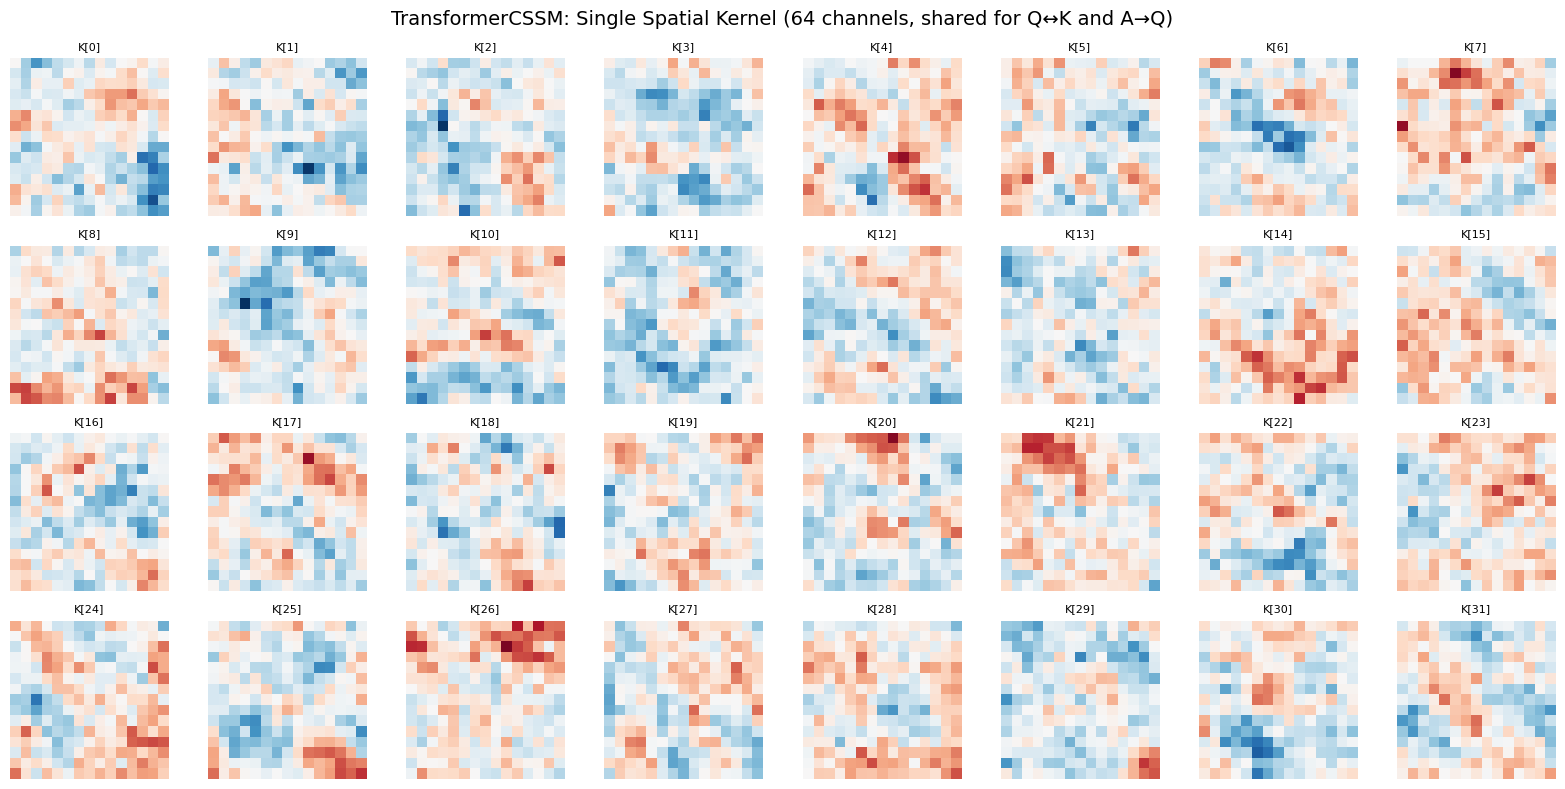

In [14]:
# Visualize the single kernel (64 channels for KQV_64 model)
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

K_np = np.array(K_kernel)
vmax = np.abs(K_np).max()

for row in range(4):
    for col in range(8):
        idx = row * 8 + col
        if idx < K_np.shape[0]:
            axes[row, col].imshow(K_np[idx], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
            axes[row, col].set_title(f'K[{idx}]', fontsize=8)
        axes[row, col].axis('off')

plt.suptitle('TransformerCSSM: Single Spatial Kernel (64 channels, shared for Q<->K and A->Q)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Load model for gradient computation
if MODEL_AVAILABLE:
    from src.models.simple_cssm import SimpleCSSM

    model = SimpleCSSM(
        num_classes=2,
        embed_dim=64,  # 64-dim model (KQV_64)
        depth=1,
        cssm_type='transformer',  # TransformerCSSM!
        kernel_size=15,
        pos_embed='spatiotemporal',
        seq_len=8,
    )
    print("[OK] TransformerCSSM model loaded (embed_dim=64)")
else:
    model = None
    print("[X] Model not available - skipping gradient analysis cells")
    print("  (Kernel visualization above still works from checkpoint)")

In [ ]:
# Images already loaded earlier (pos_img, neg_img)
# Let's display them again alongside the model's predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(pos_img)
axes[0].set_title('Positive Example (Connected)', fontsize=12)
axes[0].axis('off')
axes[1].imshow(neg_img)
axes[1].set_title('Negative Example (Disconnected)', fontsize=12)
axes[1].axis('off')
plt.suptitle('Test Images for TransformerCSSM', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Verify predictions
if MODEL_AVAILABLE and model is not None:
    def forward_single(img):
        x = jnp.array(img)[None, ...]
        x_temporal = jnp.repeat(x[:, None, ...], 8, axis=1)
        logits = model.apply({'params': params}, x_temporal, training=False)
        return logits[0]

    pos_logits = forward_single(pos_img)
    neg_logits = forward_single(neg_img)

    print("TransformerCSSM Predictions:")
    print(f"  Positive: {pos_logits} -> {'Connected' if pos_logits.argmax() == 1 else 'Disconnected'}")
    print(f"  Negative: {neg_logits} -> {'Connected' if neg_logits.argmax() == 1 else 'Disconnected'}")
else:
    print("Model not available - skipping predictions")

## 8. Temporal Gradient Attribution

How does the model's decision depend on each timestep? We compute gradients of the output with respect to the input at each of the 8 timesteps.

In [ ]:
if MODEL_AVAILABLE and model is not None:
    def compute_temporal_gradients(img, target_class):
        x = jnp.array(img)[None, ...]
        x_temporal = jnp.repeat(x[:, None, ...], 8, axis=1)

        def forward_fn(x_t):
            logits = model.apply({'params': params}, x_t, training=False)
            return logits[0, target_class]

        grads = jax.grad(forward_fn)(x_temporal)
        grad_magnitude = jnp.abs(grads).sum(axis=(0, 2, 3, 4))
        spatial_grads = jnp.abs(grads[0]).sum(axis=-1)
        return grad_magnitude, spatial_grads

    pos_grad_mag, pos_spatial = compute_temporal_gradients(pos_img, 1)
    neg_grad_mag, neg_spatial = compute_temporal_gradients(neg_img, 0)

    print("Gradient magnitude per timestep:")
    print(f"  Positive: {np.array(pos_grad_mag).round(2)}")
    print(f"  Negative: {np.array(neg_grad_mag).round(2)}")
else:
    pos_grad_mag, neg_grad_mag = None, None
    print("Model not available - skipping temporal gradient analysis")

In [ ]:
# Plot temporal importance
if pos_grad_mag is not None and neg_grad_mag is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    timesteps = np.arange(8)
    width = 0.35
    axes[0].bar(timesteps - width/2, np.array(pos_grad_mag), width,
               label='Positive', color='green', alpha=0.7)
    axes[0].bar(timesteps + width/2, np.array(neg_grad_mag), width,
               label='Negative', color='red', alpha=0.7)
    axes[0].set_xlabel('Timestep', fontsize=12)
    axes[0].set_ylabel('Gradient Magnitude', fontsize=12)
    axes[0].set_title('TransformerCSSM: Temporal Importance', fontsize=14)
    axes[0].legend()
    axes[0].set_xticks(timesteps)

    # Cumulative
    pos_cumsum = np.cumsum(np.array(pos_grad_mag))
    neg_cumsum = np.cumsum(np.array(neg_grad_mag))
    axes[1].plot(timesteps, pos_cumsum / pos_cumsum[-1], 'g-o', label='Positive', linewidth=2)
    axes[1].plot(timesteps, neg_cumsum / neg_cumsum[-1], 'r-o', label='Negative', linewidth=2)
    axes[1].set_xlabel('Timestep', fontsize=12)
    axes[1].set_ylabel('Cumulative Importance', fontsize=12)
    axes[1].set_title('Information Integration Over Time', fontsize=14)
    axes[1].legend()
    axes[1].set_xticks(timesteps)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot - gradient data not available")

## 9. Mechanism Attribution: Which Components Matter?

Which parts of the TransformerCSSM are most important for the decision? We compute gradients with respect to each learned parameter.

In [ ]:
if MODEL_AVAILABLE and model is not None:
    def parameter_gradients(img, target_class):
        x = jnp.array(img)[None, ...]
        x_temporal = jnp.repeat(x[:, None, ...], 8, axis=1)

        def loss_fn(p):
            logits = model.apply({'params': p}, x_temporal, training=False)
            return logits[0, target_class]

        return jax.grad(loss_fn)(params)

    pos_param_grads = parameter_gradients(pos_img, 1)
    neg_param_grads = parameter_gradients(neg_img, 0)
    print("[OK] Computed parameter gradients")
else:
    pos_param_grads, neg_param_grads = None, None
    print("Model not available - skipping parameter gradient analysis")

In [ ]:
# TransformerCSSM-specific gates
if pos_param_grads is not None and neg_param_grads is not None:
    mechanisms = [
        ('w_qk', 'w (Q<->K coupling)', 'Symmetric Q-K interaction'),
        ('alpha', 'α (A->Q feedback)', 'Attention feeds back to Q'),
        ('gamma', 'γ (Q,K->A accum)', 'Attention accumulation rate'),
        ('decay_Q', 'λ_Q (Q memory)', 'Query state persistence'),
        ('decay_K', 'λ_K (K memory)', 'Key state persistence'),
        ('decay_A', 'λ_A (A memory)', 'Attention memory persistence'),
    ]

    print("="*80)
    print("TransformerCSSM MECHANISM ATTRIBUTION")
    print("="*80)
    print(f"{'Mechanism':<25} {'Description':<30} {'Pos':>10} {'Neg':>10}")
    print("-"*80)

    for key, name, desc in mechanisms:
        if key in pos_param_grads['cssm_0']:
            pos_mag = np.abs(np.array(pos_param_grads['cssm_0'][key])).mean()
            neg_mag = np.abs(np.array(neg_param_grads['cssm_0'][key])).mean()
            print(f"{name:<25} {desc:<30} {pos_mag:>10.6f} {neg_mag:>10.6f}")
else:
    print("Skipping mechanism attribution - parameter gradients not available")

In [ ]:
# Kernel gradient visualization
if pos_param_grads is not None and neg_param_grads is not None:
    K_grad_pos = np.array(pos_param_grads['cssm_0']['kernel'])
    K_grad_neg = np.array(neg_param_grads['cssm_0']['kernel'])

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axes[0].imshow(K_grad_pos.mean(axis=0), cmap='RdBu_r')
    axes[0].set_title('Kernel grad (Positive)', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(K_grad_neg.mean(axis=0), cmap='RdBu_r')
    axes[1].set_title('Kernel grad (Negative)', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    diff = K_grad_pos.mean(axis=0) - K_grad_neg.mean(axis=0)
    im2 = axes[2].imshow(diff, cmap='RdBu_r')
    axes[2].set_title('Difference (Pos - Neg)', fontsize=12)
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    plt.suptitle('Kernel Gradients: How Should W Change for Each Decision?', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping kernel gradient visualization - parameter gradients not available")

---
# Part IV: Summary
---

## What We've Learned

### The Problem
- **Transformers** compute attention instantly but can't iterate or backtrack
- **RNNs** can iterate but are sequential (slow on GPUs)
- **Tasks like Pathfinder** require iterative, growing-receptive-field reasoning

### The Solution: TransformerCSSM

| Component | Inspiration | Benefit |
|-----------|-------------|---------|
| Q-K interaction | Transformers | Expressive attention-like computation |
| Growing receptive field | hGRU | Local -> global reasoning over time |
| Associative scan | State Space Models | O(log T) parallel computation |
| Attention accumulator (A) | Novel | Memory of Q-K correlations over time |

### The Equations

$Q_{t+1} = \lambda_Q Q_t + w (W * K_t) + \alpha (W * A_t) + U_Q$

$K_{t+1} = w (W * Q_t) + \lambda_K K_t + U_K$

$A_{t+1} = \gamma (Q_t + K_t) + \lambda_A A_t + U_A$

### Results

| Model | Architecture | Pathfinder-14 Accuracy |
|-------|--------------|------------------------|
| Standard Transformer | 12 layers, attention | ~75% |
| hGRU (sequential RNN) | Bilinear E-I dynamics | ~90% |
| **TransformerCSSM** | Q-K-A with parallel scan | **88.50%** |

TransformerCSSM achieves near-hGRU performance while being **parallelizable**.

In [ ]:
print("="*70)
print("KEY TAKEAWAYS")
print("="*70)
print()
print("1. CSSM = RNN that runs in parallel via associative scan")
print()
print("2. Basic CSSM is limited (single state variable)")
print()
print("3. TransformerCSSM adds Q-K-A dynamics inspired by:")
print("   • Transformer attention (Q-K interaction)")
print("   • hGRU (bilinear terms, growing receptive fields)")
print()
print("4. The model achieves 88.50% on Pathfinder-14")
print("   (comparable to sequential hGRU, but parallelizable!)")
print()
print("5. Key mechanisms:")
print("   • Symmetric Q<->K coupling through spatial kernel")
print("   • A accumulates Q-K history (attention memory)")
print("   • A feeds back into Q (attention modulation)")
print()
print("="*70)